# Classification: KNeighbors and Logistic regression

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.code.data_loader import DataLoader

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns; sns.set(style="ticks", color_codes=True)

## Auxiliary methods

In [195]:
def perform_classification(X_train, y_train, X_test, y_test, knn_c, lr_c):
    knn_c.fit(X_train, y_train)
    lr_c.fit(X_train, y_train)
    
    k_n_y_pred = knn_c.predict(X_test)
    l_r_y_pred = lr_c.predict(X_test)
    
    show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

def show_quality_results(y_test, k_n_y_pred, l_r_y_pred):
    k_n_precision_sc = precision_score(y_test, k_n_y_pred)
    k_n_accuracy_sc = accuracy_score(y_test, k_n_y_pred)
    k_n_recall_sc = recall_score(y_test, k_n_y_pred)
    k_n_f1_sc = f1_score(y_test, k_n_y_pred)
    k_n_conf_matrix = confusion_matrix(y_test, k_n_y_pred)

    l_r_precision_sc = precision_score(y_test, l_r_y_pred)
    l_r_accuracy_sc = accuracy_score(y_test, l_r_y_pred)
    l_r_recall_sc = recall_score(y_test, l_r_y_pred)
    l_r_f1_sc = f1_score(y_test, l_r_y_pred)
    l_r_conf_matrix = confusion_matrix(y_test, l_r_y_pred)
    
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(k_n_conf_matrix, annot=True, fmt="d", ax=axs[0])
    sns.heatmap(l_r_conf_matrix, annot=True, fmt="d", ax=axs[1])
    axs[0].set_title("K-nearest neighbours\nPrecision: {0:f},\nRecall: {1:f},\nF-score: {2:f},\nAccuracy: {3:f}".format(k_n_precision_sc, k_n_recall_sc, k_n_f1_sc, k_n_accuracy_sc))
    axs[1].set_title("Logistic regression\nPrecision: {0:f},\nRecall: {1:f},\nF-score: {2:f},\nAccuracy: {3:f}".format(l_r_precision_sc, l_r_recall_sc, l_r_f1_sc, l_r_accuracy_sc))
    axs[0].set_xlabel("Predicted classes")
    axs[1].set_xlabel("Predicted classes")
    axs[0].set_ylabel("True classes")
    axs[1].set_ylabel("True classes")
    plt.show()

def find_the_best_classifier(X, y, base_classifier, grid_search_params, metric_to_maximize):
    # Здесь, пожалуй, стоит подчеркнуть важность выбора в сторону стратифицированной валидации, поскольку речь идет о задаче классификации
    # Поскольку данный тип валидации сохраняет пропорцию классов в фолдах, мы можем предполагать, что разброс значений метрик на тесте не будет высоким.
    grid_search = GridSearchCV(
        estimator=base_classifier,
        param_grid=grid_search_params,
        cv=StratifiedKFold(n_splits=6),
        scoring={'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score),
                 'recall': make_scorer(recall_score),
                 'f1': make_scorer(f1_score)},
        refit=metric_to_maximize,
        n_jobs=8
    )
    grid_search.fit(X, y)
    return grid_search

## Initial data loading

In [4]:
with open('../data/description/datasets', 'r') as source:
    datasets = source.readlines()
datasets = [dataset.replace('\n', '') for dataset in datasets]
dataset_path_pattern = '../data/{}/{}.{}.txt'
data_paths = [dataset_path_pattern.format('train', dataset, 'data') for dataset in datasets] + [dataset_path_pattern.format('test', dataset, 'test') for dataset in datasets]
data_loader = DataLoader(data_paths, '../data/description/columns', '../data/description/classes')
data_frame = data_loader.load()

## Dataset description

Собственно датасет представляет собой описание симптомов пациентов.

Цель - определение заболевания щитовидной железы (соответственно диагноз - целевая переменная).

Данные резбиты на несколько файлов, шесть пар файлов (для обучения и контроля) имеют одинаковою структуру, остальные отличаются по количеству признаков и порядку следования.

В данной работе используются только эти шесть пар файлов.

Также стоит отметить, что целевая переменная в разных файлах имеет разное количество разных диагнозов, однако все в целом могут быть разделены на две группы: здоров, болен.

Здесь задача многоклассовой классификации сводится к бинарной.

## EDA

In [5]:
data_frame.head(30)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,diagnosis
0,41.0,1.0,False,False,False,False,False,False,False,False,...,True,125.0,True,1.14,True,109.0,False,None,SVHC,False
1,23.0,1.0,False,False,False,False,False,False,False,False,...,True,102.0,False,NaN,False,NaN,False,None,other,False
2,46.0,0.0,False,False,False,False,False,False,False,False,...,True,109.0,True,0.91,True,120.0,False,None,other,False
3,70.0,1.0,True,False,False,False,False,False,False,False,...,True,175.0,False,NaN,False,NaN,False,None,other,False
4,70.0,1.0,False,False,False,False,False,False,False,False,...,True,61.0,True,0.87,True,70.0,False,None,SVI,False
5,18.0,1.0,True,False,False,False,False,False,False,False,...,True,183.0,True,1.30,True,141.0,False,None,other,False
6,59.0,1.0,False,False,False,False,False,False,False,False,...,True,72.0,True,0.92,True,78.0,False,None,other,False
7,80.0,1.0,False,False,False,False,False,False,False,False,...,True,80.0,True,0.70,True,115.0,False,None,SVI,True
8,66.0,1.0,False,False,False,False,False,False,False,False,...,True,123.0,True,0.93,True,132.0,False,None,SVI,False
9,68.0,0.0,False,False,False,False,False,False,False,False,...,True,83.0,True,0.89,True,93.0,False,None,SVI,False


In [6]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22632 entries, 0 to 971
Data columns (total 30 columns):
age                          22626 non-null float64
sex                          21732 non-null float64
on thyroxine                 22632 non-null bool
query on thyroxine           22632 non-null bool
on antithyroid medication    22632 non-null bool
sick                         22632 non-null bool
pregnant                     22632 non-null bool
thyroid surgery              22632 non-null bool
I131 treatment               22632 non-null bool
query hypothyroid            22632 non-null bool
query hyperthyroid           22632 non-null bool
lithium                      22632 non-null bool
goitre                       22632 non-null bool
tumor                        22632 non-null bool
hypopituitary                22632 non-null bool
psych                        22632 non-null bool
TSH measured                 22632 non-null bool
TSH                          20418 non-null float64
T3

После объединения могло возникнуть некоторое количество дупликатов, попробуем от них избавиться:

In [7]:
data_frame.drop_duplicates(inplace=True)

In [8]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 30 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH measured                 4619 non-null bool
TSH                          4286 non-null float64
T3 measured          

Судя по всему подавляющее большинство информации в датастах было дуплицировано.
Это также может быть объяснено тем, что все случаи положительных диагнозов были схлопнуты в один, поэтому пациенты с одинаковыми симптомами, но разными диагнозами из разных выборок стали идентичными.

Из описания видно, что признак TBG не содержит ни одного ненулевого значения, соответственно значение данного признака не было измерено ни для одного пациента. Данный признак (а соответственно и признак TBG measured) можно удалить из выборки:

In [9]:
data_frame.drop(['TBG measured', 'TBG'], axis='columns', inplace=True)

In [10]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 28 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH measured                 4619 non-null bool
TSH                          4286 non-null float64
T3 measured          

Заметим, что TSH measured, T3 measured, TT4 measured, T4U measured и FTI measured просто показывают, было ли измерено у пациента значение признаков TSH, T3, TT4, T4U и FTI соответственно. Данная информация избыточна, поскольку по значению этих признаков можно понять были они измерены или нет (наличие или отсутствие NaN), TSH measured, T3 measured, TT4 measured, T4U measured и FTI measured также можно удалить из выборки:

In [11]:
data_frame.drop(['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured'], axis='columns', inplace=True)

In [12]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 23 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH                          4286 non-null float64
T3                           3778 non-null float64
TT4               

Заметим, что в данных присутствуют записи о неопределившихся с полом:

In [13]:
data_frame[(data_frame.sex.isnull())].sort_index().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 16 to 2786
Data columns (total 23 columns):
age                          184 non-null float64
sex                          0 non-null float64
on thyroxine                 184 non-null bool
query on thyroxine           184 non-null bool
on antithyroid medication    184 non-null bool
sick                         184 non-null bool
pregnant                     184 non-null bool
thyroid surgery              184 non-null bool
I131 treatment               184 non-null bool
query hypothyroid            184 non-null bool
query hyperthyroid           184 non-null bool
lithium                      184 non-null bool
goitre                       184 non-null bool
tumor                        184 non-null bool
hypopituitary                184 non-null bool
psych                        184 non-null bool
TSH                          165 non-null float64
T3                           156 non-null float64
TT4                          169 non-

Глянем, есть ли среди неопределившихся с полом беременные:

In [14]:
data_frame[(data_frame.sex.isnull()) & (data_frame.pregnant)]

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,diagnosis
1609,73.0,NaN,False,False,False,False,True,False,False,False,...,False,False,False,2.2,2.5,110.0,1.28,85.0,other,False
471,21.0,NaN,False,False,False,False,True,False,False,False,...,True,False,False,2.4,3.5,171.0,1.49,115.0,STMW,False
471,21.0,NaN,False,False,False,False,True,False,False,False,...,True,False,False,2.4,3.5,171.0,1.49,115.0,STMW,True


Поскольку пол - довольно важный признак и поскольку неопределившиеся составляют $100 \cdot \frac{185}{4680} \approx 4\%$, будет проще избавиться от данной части выборки:

In [15]:
patients_without_sex = data_frame[(data_frame.sex.isnull())]
data_frame.drop(data_frame[(data_frame.sex.isnull())].index, inplace=True)

In [16]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4341 entries, 0 to 909
Data columns (total 23 columns):
age                          4340 non-null float64
sex                          4341 non-null float64
on thyroxine                 4341 non-null bool
query on thyroxine           4341 non-null bool
on antithyroid medication    4341 non-null bool
sick                         4341 non-null bool
pregnant                     4341 non-null bool
thyroid surgery              4341 non-null bool
I131 treatment               4341 non-null bool
query hypothyroid            4341 non-null bool
query hyperthyroid           4341 non-null bool
lithium                      4341 non-null bool
goitre                       4341 non-null bool
tumor                        4341 non-null bool
hypopituitary                4341 non-null bool
psych                        4341 non-null bool
TSH                          4032 non-null float64
T3                           3538 non-null float64
TT4               

Остался еще один пациент, у которого не указан возраст:

In [17]:
data_frame[(data_frame.age.isnull())]

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,diagnosis
1985,NaN,1.0,True,False,False,False,False,False,True,False,...,False,False,False,0.6,1.5,120.0,0.82,146.0,other,False


Можно было бы посчитать сколько-нибудь ближайших к данному персонажу личностей потом по медиане взять возраст,
однако для этого нужно либо ранжировать всю выборку либо случайным образом доставать похожих по симптомам пациентов.
Гораздо проще исключить пока этот объект из выборки, поскольку вряд ли отсутствие одного пациента существенно сместит результаты обучения:

In [18]:
data_frame.drop(data_frame[(data_frame.age.isnull())].index, inplace=True)

In [19]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4340 entries, 0 to 909
Data columns (total 23 columns):
age                          4340 non-null float64
sex                          4340 non-null float64
on thyroxine                 4340 non-null bool
query on thyroxine           4340 non-null bool
on antithyroid medication    4340 non-null bool
sick                         4340 non-null bool
pregnant                     4340 non-null bool
thyroid surgery              4340 non-null bool
I131 treatment               4340 non-null bool
query hypothyroid            4340 non-null bool
query hyperthyroid           4340 non-null bool
lithium                      4340 non-null bool
goitre                       4340 non-null bool
tumor                        4340 non-null bool
hypopituitary                4340 non-null bool
psych                        4340 non-null bool
TSH                          4031 non-null float64
T3                           3537 non-null float64
TT4               

Извлечем пока из выборки признак referal source:

In [20]:
referral_source = data_frame['referral source']
data_frame.drop(['referral source'], axis='columns', inplace=True)

Отделим целевой признак (диагноз) от предикторов (первых 21 признаков):

In [21]:
y = data_frame['diagnosis']
X = data_frame.drop(['diagnosis'], axis='columns')

Теперь заметим, что в последних пяти признаках есть пропуски.

Собственно, это те пациенты, для которых показания по соответствующим признакам не были измерены.

Поскольку в используемых алгоритмах так или иначе используется суммарный вклад признаков, было бы осмысленно в качестве заполнения использовать медианы

(поскольку медиана занимает серединное положение, она не будет давать сильного смещения для объектов, которые по остальным признакам близки друг к другу, таким образом снижается шанс напороться на false-positive.

С другой стороны медиана не сместится в ситуации, когда значение признака аномально высоко/низко).

In [22]:
x_columns = X.columns

In [23]:
imputer = Imputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=x_columns)

In [24]:
X.head(30)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI
0,41.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.300,2.5,125.0,1.14,109.0
1,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.100,2.0,102.0,0.98,107.0
2,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.980,2.0,109.0,0.91,120.0
3,70.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.160,1.9,175.0,0.98,107.0
4,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.720,1.2,61.0,0.87,70.0
5,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.030,2.0,183.0,1.30,141.0
6,59.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.400,2.0,72.0,0.92,78.0
7,80.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.200,0.6,80.0,0.70,115.0
8,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.600,2.2,123.0,0.93,132.0
9,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.400,1.6,83.0,0.89,93.0


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 21 columns):
age                          4340 non-null float64
sex                          4340 non-null float64
on thyroxine                 4340 non-null float64
query on thyroxine           4340 non-null float64
on antithyroid medication    4340 non-null float64
sick                         4340 non-null float64
pregnant                     4340 non-null float64
thyroid surgery              4340 non-null float64
I131 treatment               4340 non-null float64
query hypothyroid            4340 non-null float64
query hyperthyroid           4340 non-null float64
lithium                      4340 non-null float64
goitre                       4340 non-null float64
tumor                        4340 non-null float64
hypopituitary                4340 non-null float64
psych                        4340 non-null float64
TSH                          4340 non-null float64
T3                        

Теперь нормализуем признаки, удалив среднее и разделив на отклонение:

In [26]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=x_columns)

In [27]:
X.describe().applymap(lambda x: round(x, 3))

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI
count,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,...,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000,4340.000
mean,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,...,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.540,-1.509,-0.392,-0.115,-0.110,-0.204,-0.145,-0.115,-0.120,-0.275,...,-0.068,-0.093,-0.174,-0.021,-0.218,-0.230,-2.235,-2.675,-3.625,-3.003
25%,-0.802,-1.509,-0.392,-0.115,-0.110,-0.204,-0.145,-0.115,-0.120,-0.275,...,-0.068,-0.093,-0.174,-0.021,-0.218,-0.213,-0.464,-0.556,-0.591,-0.486
50%,0.142,0.663,-0.392,-0.115,-0.110,-0.204,-0.145,-0.115,-0.120,-0.275,...,-0.068,-0.093,-0.174,-0.021,-0.218,-0.182,-0.006,-0.132,-0.109,-0.099
75%,0.788,0.663,-0.392,-0.115,-0.110,-0.204,-0.145,-0.115,-0.120,-0.275,...,-0.068,-0.093,-0.174,-0.021,-0.218,-0.126,0.336,0.442,0.373,0.371
max,20.008,0.663,2.549,8.668,9.081,4.908,6.911,8.668,8.307,3.631,...,14.697,10.784,5.760,46.573,4.586,18.250,9.821,7.995,6.345,7.865


## Model building

Итак, у нас есть некий базовый слепок выборки, теперь попробуем обучить логистическую регрессию и метод К-ближайших соседей.

Да, вот так вслепую, без особого вмешательства, просто чтобы глянуть, что получится, если не предпринимать никаких шагов.

Разделим предварительно выборку на обучающую и тестовую:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

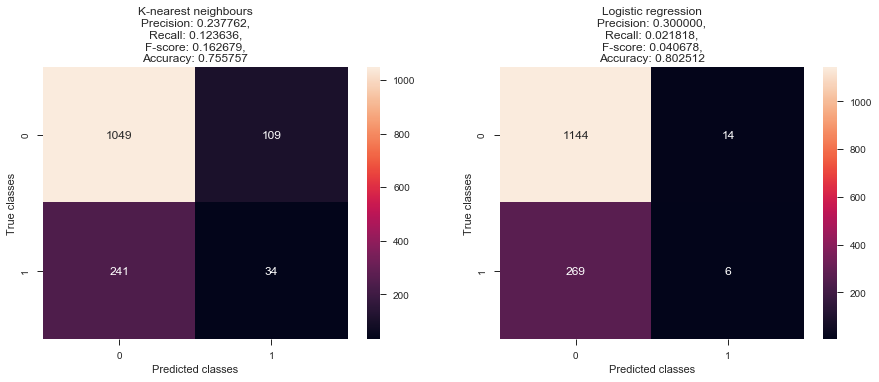

In [29]:
perform_classification(X_train, y_train, X_test, y_test, KNeighborsClassifier(), LogisticRegression())

Собственно, ничего особо хорошего не получилось.

Что в первом, что во втором случае значения **Precision** и **Recall** очень низкие.

Безусловно это плохо, поскольку речь идет о здоровье людей.

В случае, когда мы по собранным данным приходим к выводу, что с пациентом что-то не в порядке, мы можем отправить его на повторное обследование, собрать больше данных и сделать более уверенный прогноз.

Если же мы говорим, что пациент здоров (а он при этом болен), то даем заболеванию развиться.

Глянем на распределение классов в обучающей и контрольной выборке:

In [30]:
y_train.value_counts()

False    2329
True      578
Name: diagnosis, dtype: int64

In [31]:
y_test.value_counts()

False    1158
True      275
Name: diagnosis, dtype: int64

Распределение классов сильно смещено в сторону здоровых пациентов.

Глянем, сколько есть больных пациентов в той части выборки, где не указан пол (может за счет этой части выборки удастся сбалансировать классы):

In [32]:
patients_without_sex['diagnosis'].value_counts()

False    149
True      35
Name: diagnosis, dtype: int64

## Imbalanced classes handling

Собственно, как и следовало ожидать, больных пациентов значительно меньше, чем здоровых.

Получается, что классификаторы в процессе обучения настраиваются таким образом, чтобы минимизировать общее количество ошибок, без учета стоимости Ошибок I-го рода.

Есть два основных подхода для устранения этой проблемы:
    - Undersampling;
    - Oversampling.
Попробуем применить некоторые методы Undersampling-а. Для этого используем [данную библиотеку](http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html)

In [33]:
random_undersampler = RandomUnderSampler(return_indices=True, random_state=42)
X_train_resampled, y_train_resampled, idx_train_resampled = random_undersampler.fit_sample(X_train, y_train)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=x_columns)
y_train_resampled = pd.Series(y_train_resampled)

Теперь посмотрим на то, как изменилось соотношение классов:

In [34]:
y_train_resampled.value_counts()

True     578
False    578
dtype: int64

Итак, мы случайным образов извлекли необходимое количество здоровых пациентов из обучающей выборки.

Попробуем теперь обучить классификаторы на новых данных:

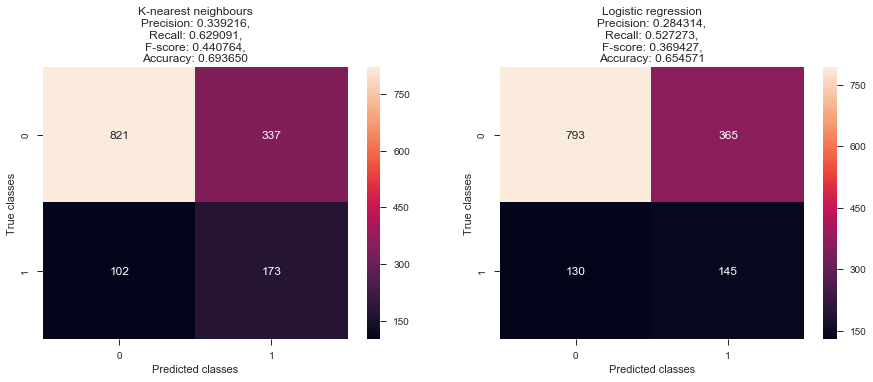

In [35]:
perform_classification(X_train_resampled, y_train_resampled, X_test, y_test, KNeighborsClassifier(), LogisticRegression())

Лучше, чем было. Попробуем теперь другой способ, основанный на кластеризации по методу K-средних:

In [36]:
cluster_undersampler = ClusterCentroids(random_state=42)
X_train_resampled, y_train_resampled = cluster_undersampler.fit_sample(X_train, y_train)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=x_columns)
y_train_resampled = pd.Series(y_train_resampled)

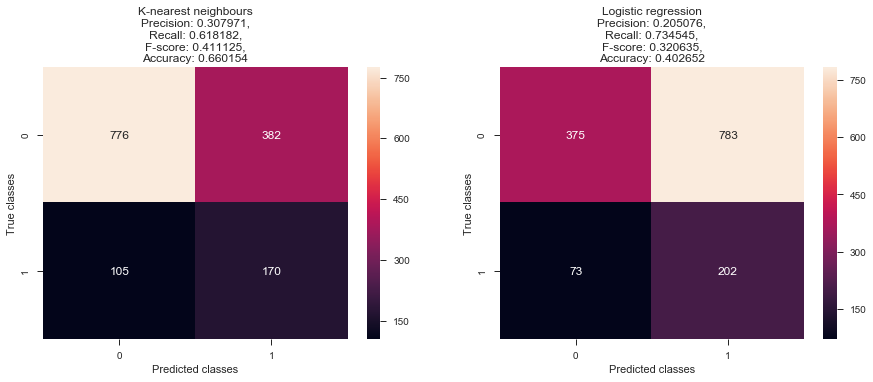

In [37]:
perform_classification(X_train_resampled, y_train_resampled, X_test, y_test, KNeighborsClassifier(), LogisticRegression())

Примечательно, что во втором случае существенно повысилась полнота для логистической регрессии, однако оба алгоритма стали совершать больше false positives.

## Hyperparameters tunning: Random undersampling

Что же, в целом после балансировки результаты лучше, однако данные результаты были получены при дефолтных гиперпараметрах моделей.

Необходимо подобрать некую комбинацию гиперпараметров, которая давала бы на выходе максимальные значения интересующих нас метрик качества:

In [38]:
random_undersampler = RandomUnderSampler(return_indices=True, random_state=42)
X_test_resampled, y_test_resampled, idx_test_resampled = random_undersampler.fit_sample(X_test, y_test)
X_test_resampled = pd.DataFrame(X_test_resampled, columns=x_columns)
y_test_resampled = pd.Series(y_test_resampled)

In [39]:
y_test_resampled.value_counts()

True     275
False    275
dtype: int64

In [40]:
X = pd.concat([X_train_resampled, X_test_resampled])
y = pd.concat([y_train_resampled, y_test_resampled])

In [41]:
y.value_counts()

True     853
False    853
dtype: int64

Определим теперь набор гиперпараметров и их значений, которые будут использованы для поиска оптимальной комбинации:

In [42]:
n_neighbors = [3, 4, 5, 6, 7, 8]
leaf_size = [10, 15, 20, 25]
p = [1, 2, 3]
algorithm = ['auto', 'ball_tree', 'kd_tree']
k_n_grid_search_params = [
    {'weights': ['uniform'], 'n_neighbors': n_neighbors, 'leaf_size': leaf_size, 'p': p, 'algorithm': algorithm},
    {'weights': ['distance'], 'n_neighbors': n_neighbors, 'leaf_size': leaf_size, 'p': p, 'algorithm': algorithm}
]

In [43]:
Alphas = np.arange(0.1, 1.0, 0.01)
class_weight = [{False: 1.0, True: w} for w in np.arange(1, 7.0, 0.1)]
l_r_grid_search_params = [
    {'penalty': ['l1'], 'C': Alphas, 'fit_intercept': [True, False], 'class_weight': class_weight},
    {'penalty': ['l2'], 'C': Alphas, 'fit_intercept': [True, False], 'class_weight': class_weight}
]

In [44]:
k_n_classifier = KNeighborsClassifier()
r_k_n_grid_search = find_the_best_classifier(X, y, k_n_classifier, k_n_grid_search_params, 'recall')

In [45]:
l_r_classifier = LogisticRegression(random_state=42)
r_l_r_grid_search = find_the_best_classifier(X, y, l_r_classifier, l_r_grid_search_params, 'recall')

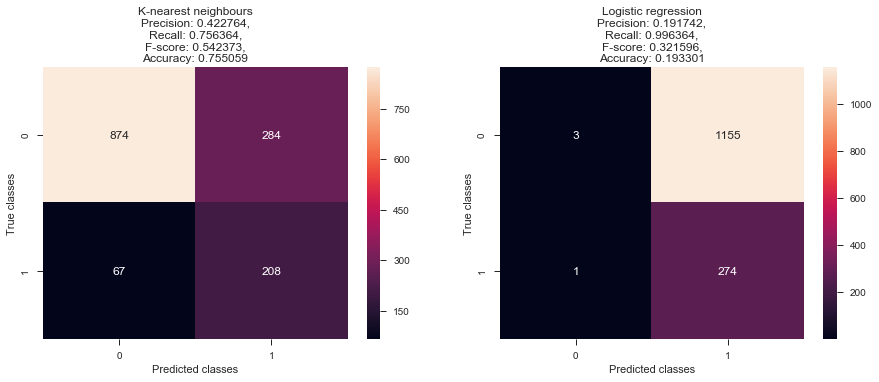

In [46]:
k_n_y_pred = r_k_n_grid_search.best_estimator_.predict(X_test)
l_r_y_pred = r_l_r_grid_search.best_estimator_.predict(X_test)
show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

## Hyperparameters tunning: Centroids undersampling

Теперь попробуем также найти оптимальную комбинацию гиперпараметров для логистической регрессии при втором методе undersampling-а:

In [47]:
cluster_undersampler = ClusterCentroids(random_state=42)
X_train_resampled, y_train_resampled = cluster_undersampler.fit_sample(X_train, y_train)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=x_columns)
y_train_resampled = pd.Series(y_train_resampled)

cluster_undersampler = ClusterCentroids(random_state=42)
X_test_resampled, y_test_resampled = cluster_undersampler.fit_sample(X_test, y_test)
X_test_resampled = pd.DataFrame(X_test_resampled, columns=x_columns)
y_test_resampled = pd.Series(y_test_resampled)

X = pd.concat([X_train_resampled, X_test_resampled])
y = pd.concat([y_train_resampled, y_test_resampled])

In [48]:
k_n_classifier = KNeighborsClassifier()
c_k_n_grid_search = find_the_best_classifier(X, y, k_n_classifier, k_n_grid_search_params, 'recall')

In [49]:
l_r_classifier = LogisticRegression(random_state=42)
c_l_r_grid_search = find_the_best_classifier(X, y, l_r_classifier, l_r_grid_search_params, 'precision')

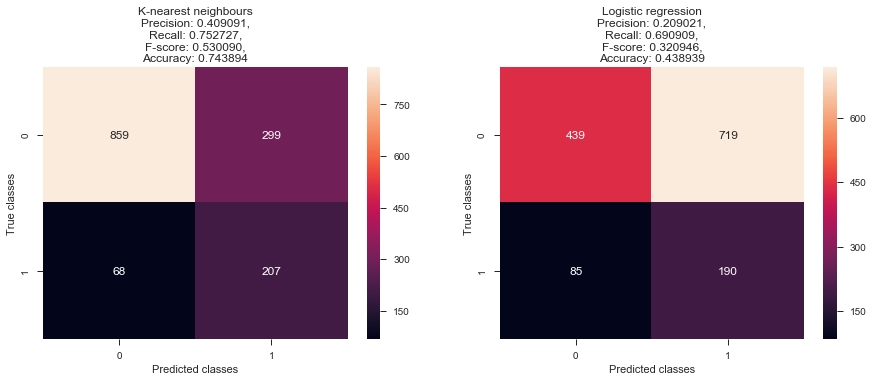

In [50]:
k_n_y_pred = c_k_n_grid_search.best_estimator_.predict(X_test)
l_r_y_pred = c_l_r_grid_search.best_estimator_.predict(X_test)
show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

Теперь попробуем вывести парочку графиков с тем, чтобы понять, как при разных стратегиях undersampling-а значения гиперпараметров влияют на качество классификации:

Сначала надо извлечь средние значения и отклонения метрик на кросс-валидации:

In [111]:
r_k_n_mean_test_accuracy = np.reshape(r_k_n_grid_search.cv_results_['mean_test_accuracy'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
r_k_n_mean_test_precision = np.reshape(r_k_n_grid_search.cv_results_['mean_test_precision'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
r_k_n_mean_test_recall = np.reshape(r_k_n_grid_search.cv_results_['mean_test_recall'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
r_k_n_mean_test_f1 = np.reshape(r_k_n_grid_search.cv_results_['mean_test_f1'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))

r_l_r_mean_test_accuracy = np.reshape(r_l_r_grid_search.cv_results_['mean_test_accuracy'], (2, 2, len(class_weight),len(Alphas)))
r_l_r_mean_test_precision = np.reshape(r_l_r_grid_search.cv_results_['mean_test_precision'], (2, 2, len(class_weight),len(Alphas)))
r_l_r_mean_test_recall = np.reshape(r_l_r_grid_search.cv_results_['mean_test_recall'], (2, 2, len(class_weight),len(Alphas)))
r_l_r_mean_test_f1 = np.reshape(r_l_r_grid_search.cv_results_['mean_test_f1'], (2, 2, len(class_weight),len(Alphas)))

c_k_n_mean_test_accuracy = np.reshape(c_k_n_grid_search.cv_results_['mean_test_accuracy'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
c_k_n_mean_test_precision = np.reshape(c_k_n_grid_search.cv_results_['mean_test_precision'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
c_k_n_mean_test_recall = np.reshape(c_k_n_grid_search.cv_results_['mean_test_recall'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
c_k_n_mean_test_f1 = np.reshape(c_k_n_grid_search.cv_results_['mean_test_f1'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))

c_l_r_mean_test_accuracy = np.reshape(c_l_r_grid_search.cv_results_['mean_test_accuracy'], (2, 2, len(class_weight),len(Alphas)))
c_l_r_mean_test_precision = np.reshape(c_l_r_grid_search.cv_results_['mean_test_precision'], (2, 2, len(class_weight),len(Alphas)))
c_l_r_mean_test_recall = np.reshape(c_l_r_grid_search.cv_results_['mean_test_recall'], (2, 2, len(class_weight),len(Alphas)))
c_l_r_mean_test_f1 = np.reshape(c_l_r_grid_search.cv_results_['mean_test_f1'], (2, 2, len(class_weight),len(Alphas)))


r_k_n_std_test_accuracy = np.reshape(r_k_n_grid_search.cv_results_['std_test_accuracy'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
r_k_n_std_test_precision = np.reshape(r_k_n_grid_search.cv_results_['std_test_precision'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
r_k_n_std_test_recall = np.reshape(r_k_n_grid_search.cv_results_['std_test_recall'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
r_k_n_std_test_f1 = np.reshape(r_k_n_grid_search.cv_results_['std_test_f1'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))

r_l_r_std_test_accuracy = np.reshape(r_l_r_grid_search.cv_results_['std_test_accuracy'], (2, 2, len(class_weight),len(Alphas)))
r_l_r_std_test_precision = np.reshape(r_l_r_grid_search.cv_results_['std_test_precision'], (2, 2, len(class_weight),len(Alphas)))
r_l_r_std_test_recall = np.reshape(r_l_r_grid_search.cv_results_['std_test_recall'], (2, 2, len(class_weight),len(Alphas)))
r_l_r_std_test_f1 = np.reshape(r_l_r_grid_search.cv_results_['std_test_f1'], (2, 2, len(class_weight),len(Alphas)))

c_k_n_std_test_accuracy = np.reshape(c_k_n_grid_search.cv_results_['std_test_accuracy'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
c_k_n_std_test_precision = np.reshape(c_k_n_grid_search.cv_results_['std_test_precision'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
c_k_n_std_test_recall = np.reshape(c_k_n_grid_search.cv_results_['std_test_recall'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))
c_k_n_std_test_f1 = np.reshape(c_k_n_grid_search.cv_results_['std_test_f1'], (len(algorithm), len(leaf_size), len(n_neighbors), len(p), 2))

c_l_r_std_test_accuracy = np.reshape(c_l_r_grid_search.cv_results_['std_test_accuracy'], (2, 2, len(class_weight),len(Alphas)))
c_l_r_std_test_precision = np.reshape(c_l_r_grid_search.cv_results_['std_test_precision'], (2, 2, len(class_weight),len(Alphas)))
c_l_r_std_test_recall = np.reshape(c_l_r_grid_search.cv_results_['std_test_recall'], (2, 2, len(class_weight),len(Alphas)))
c_l_r_std_test_f1 = np.reshape(c_l_r_grid_search.cv_results_['std_test_f1'], (2, 2, len(class_weight),len(Alphas)))

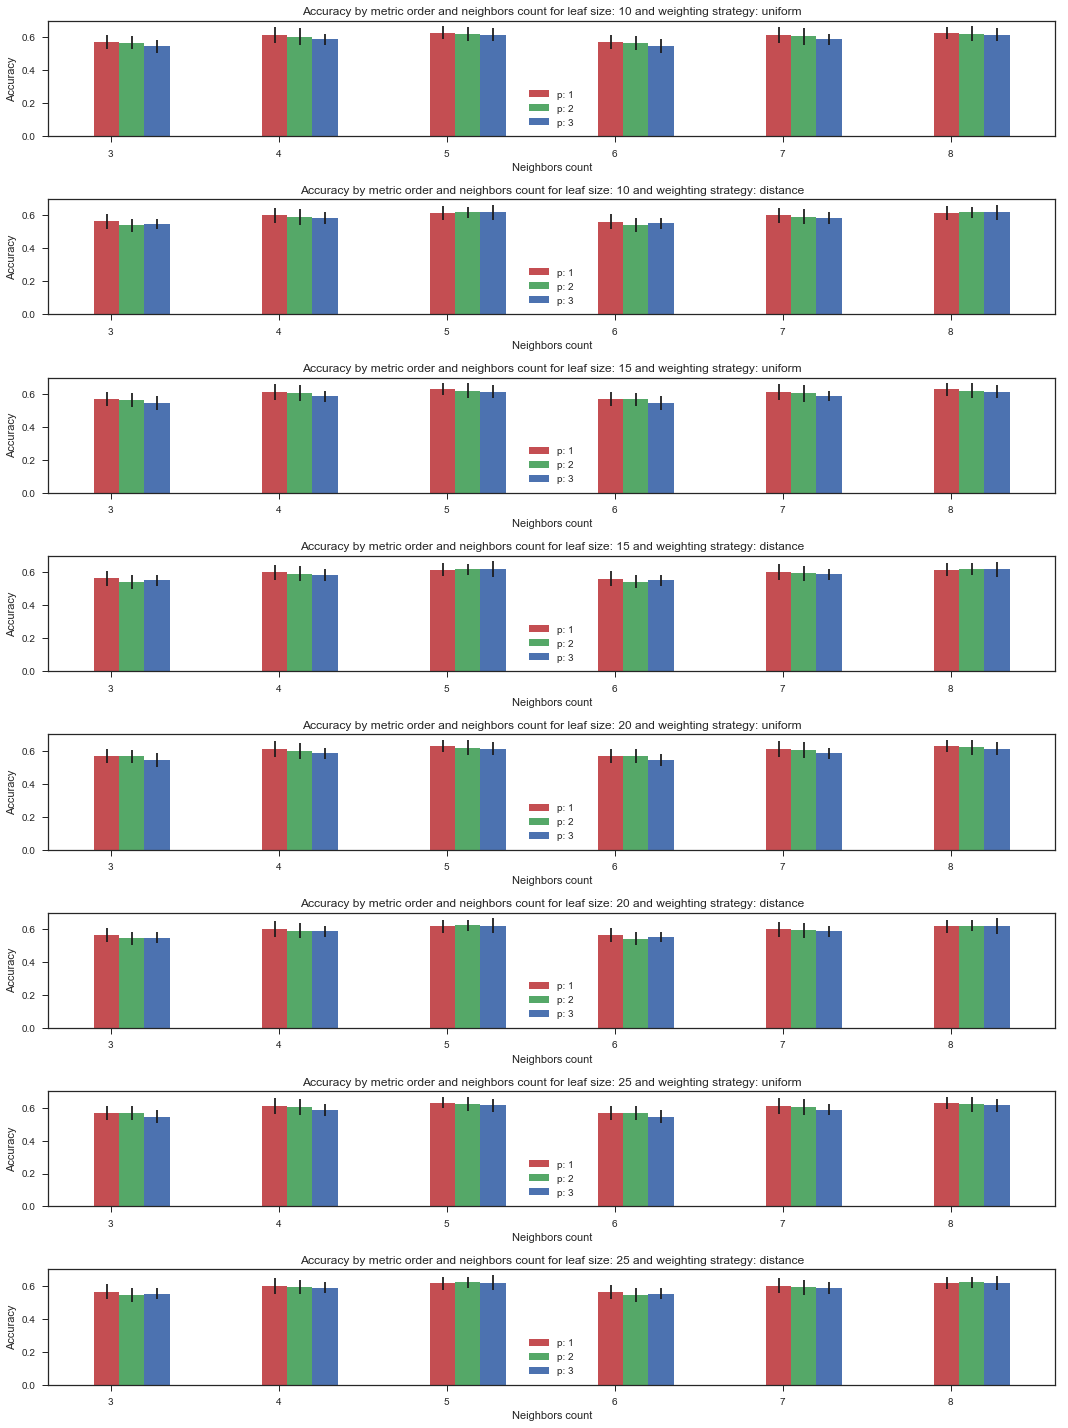

In [194]:
N = 6
ind = np.arange(N)
width = 0.15
fig, ax = plt.subplots(8, figsize=(15, 20))

ax[0].bar(ind, r_k_n_mean_test_accuracy[0, 0, 0:, 0:, 0][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 0, 0:, 0:, 0][0:, 0])
ax[0].bar(ind + width, r_k_n_mean_test_accuracy[0, 0, 0:, 0:, 0][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 0, 0:, 0:, 0][0:, 1])
ax[0].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 0, 0:, 0:, 0][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 0, 0:, 0:, 0][0:, 2])

ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Neighbors count')
ax[0].set_title('Accuracy by metric order and neighbors count for leaf size: 10 and weighting strategy: uniform')
ax[0].set_xticks(ind + width / 6)
ax[0].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[0].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)

ax[1].bar(ind, r_k_n_mean_test_accuracy[0, 0, 0:, 0:, 1][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 0, 0:, 0:, 1][0:, 0])
ax[1].bar(ind + width, r_k_n_mean_test_accuracy[0, 0, 0:, 0:, 1][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 0, 0:, 0:, 1][0:, 1])
ax[1].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 0, 0:, 0:, 1][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 0, 0:, 0:, 1][0:, 2])

ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Neighbors count')
ax[1].set_title('Accuracy by metric order and neighbors count for leaf size: 10 and weighting strategy: distance')
ax[1].set_xticks(ind + width / 6)
ax[1].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[1].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)

ax[2].bar(ind, r_k_n_mean_test_accuracy[0, 1, 0:, 0:, 0][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 1, 0:, 0:, 0][0:, 0])
ax[2].bar(ind + width, r_k_n_mean_test_accuracy[0, 1, 0:, 0:, 0][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 1, 0:, 0:, 0][0:, 1])
ax[2].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 1, 0:, 0:, 0][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 1, 0:, 0:, 0][0:, 2])

ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Neighbors count')
ax[2].set_title('Accuracy by metric order and neighbors count for leaf size: 15 and weighting strategy: uniform')
ax[2].set_xticks(ind + width / 6)
ax[2].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[2].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)

ax[3].bar(ind, r_k_n_mean_test_accuracy[0, 1, 0:, 0:, 1][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 1, 0:, 0:, 1][0:, 0])
ax[3].bar(ind + width, r_k_n_mean_test_accuracy[0, 1, 0:, 0:, 1][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 1, 0:, 0:, 1][0:, 1])
ax[3].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 1, 0:, 0:, 1][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 1, 0:, 0:, 1][0:, 2])

ax[3].set_ylabel('Accuracy')
ax[3].set_xlabel('Neighbors count')
ax[3].set_title('Accuracy by metric order and neighbors count for leaf size: 15 and weighting strategy: distance')
ax[3].set_xticks(ind + width / 6)
ax[3].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[3].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)

ax[4].bar(ind, r_k_n_mean_test_accuracy[0, 2, 0:, 0:, 0][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 2, 0:, 0:, 0][0:, 0])
ax[4].bar(ind + width, r_k_n_mean_test_accuracy[0, 2, 0:, 0:, 0][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 2, 0:, 0:, 0][0:, 1])
ax[4].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 2, 0:, 0:, 0][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 2, 0:, 0:, 0][0:, 2])

ax[4].set_ylabel('Accuracy')
ax[4].set_xlabel('Neighbors count')
ax[4].set_title('Accuracy by metric order and neighbors count for leaf size: 20 and weighting strategy: uniform')
ax[4].set_xticks(ind + width / 6)
ax[4].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[4].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)

ax[5].bar(ind, r_k_n_mean_test_accuracy[0, 2, 0:, 0:, 1][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 2, 0:, 0:, 1][0:, 0])
ax[5].bar(ind + width, r_k_n_mean_test_accuracy[0, 2, 0:, 0:, 1][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 2, 0:, 0:, 1][0:, 1])
ax[5].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 2, 0:, 0:, 1][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 2, 0:, 0:, 1][0:, 2])

ax[5].set_ylabel('Accuracy')
ax[5].set_xlabel('Neighbors count')
ax[5].set_title('Accuracy by metric order and neighbors count for leaf size: 20 and weighting strategy: distance')
ax[5].set_xticks(ind + width / 6)
ax[5].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[5].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)

ax[6].bar(ind, r_k_n_mean_test_accuracy[0, 3, 0:, 0:, 0][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 3, 0:, 0:, 0][0:, 0])
ax[6].bar(ind + width, r_k_n_mean_test_accuracy[0, 3, 0:, 0:, 0][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 3, 0:, 0:, 0][0:, 1])
ax[6].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 3, 0:, 0:, 0][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 3, 0:, 0:, 0][0:, 2])

ax[6].set_ylabel('Accuracy')
ax[6].set_xlabel('Neighbors count')
ax[6].set_title('Accuracy by metric order and neighbors count for leaf size: 25 and weighting strategy: uniform')
ax[6].set_xticks(ind + width / 6)
ax[6].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[6].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)

ax[7].bar(ind, r_k_n_mean_test_accuracy[0, 3, 0:, 0:, 1][0:, 0], width, color='r', yerr=r_k_n_std_test_accuracy[0, 3, 0:, 0:, 1][0:, 0])
ax[7].bar(ind + width, r_k_n_mean_test_accuracy[0, 3, 0:, 0:, 1][0:, 1], width, color='g', yerr=r_k_n_std_test_accuracy[0, 3, 0:, 0:, 1][0:, 1])
ax[7].bar(ind + 2 * width, r_k_n_mean_test_accuracy[0, 3, 0:, 0:, 1][0:, 2], width, color='b', yerr=r_k_n_std_test_accuracy[0, 3, 0:, 0:, 1][0:, 2])

ax[7].set_ylabel('Accuracy')
ax[7].set_xlabel('Neighbors count')
ax[7].set_title('Accuracy by metric order and neighbors count for leaf size: 25 and weighting strategy: distance')
ax[7].set_xticks(ind + width / 6)
ax[7].set_xticklabels(('3', '4', '5', '6', '7', '8'))
ax[7].legend(('p: 1', 'p: 2', 'p: 3'), loc=0)
plt.tight_layout()
plt.show()

Судя по графику в подавляющем большинстве случаев метрика Манхэттена оказывается более удачной, нежели Евклидова или Минковского III-го порядка.

## Conclusion

Итак в данной работе была:
    - проведена предварительная обработка данных посредством заполнения пропусков, нормализации признаков, исклучения неинформативных признаков и т.д.;
    - построена базовая модель для логистической регресси и медота К-ближайших соседей;
    - проверено два способа undersampling-а с использованием поиска оптимальных гиперпараметров по сетке и стратифицированного перекрестного контроля;
    - графически отображена зависимость Accuracy от различных значений гиперпараметров для Метода К-ближайших соседей.

То, что не вошло в данную работу, но, возможно, улучшило бы качество классификации:
    - включение referal source в выборку с последующей его бинаризацией;
    - использование других способов заполнения пропусков;
    - использование других стратегий undersampling-а, а также стратегий oversampling-а;
    - использование данных о больных, у которых не был указан пол.

Стоит отметить, что использование undersampling-a существенно повысило качество классификации, дальнейший поиск оптимальной комбинации гиперпараметров также улучшил качество, но в меньшей степени.

В целом, по имеющимся оценкам качества можно прийти к выводу, что метод К-ближайших соседей работает лучше, поскольку при схожей полноте оказывается при этом более точным.